## Applying Deterministic Methods
### Getting Started
This tutorial focuses on using deterministic methods to square a triangle. 

Note that a lot of the examples shown here might not be applicable in a real world scenario, and is only meant to demonstrate some of the functionalities included in the package. The user should always exercise their best actuarial judgement, and follow any applicable laws, the Code of Professional Conduct, and applicable Actuarial Standards of Practice.

Be sure to make sure your packages are updated. For more info on how to update your pakages, visit [Keeping Packages Updated](https://chainladder-python.readthedocs.io/en/latest/install.html#keeping-packages-updated).

In [1]:
# Black linter, optional
%load_ext lab_black

import pandas as pd
import numpy as np
import chainladder as cl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
print("chainladder: " + cl.__version__)

pandas: 1.3.4
numpy: 1.21.2
chainladder: 0.8.10


### The Chainladder Method

The basic chainladder method is entirely specified by its development pattern selections. For this reason, the `Chainladder` estimator takes no additional assumptions, i.e. no additional arguments. Let's start by loading an example dataset and creating an Triangle with `Development` patterns and a `TailCurve`.  Recall, we can bundle these two estimators into a single `Pipeline` if we wish.

In [2]:
genins = cl.load_sample("genins")

genins_dev = cl.Pipeline(
    [("dev", cl.Development()), ("tail", cl.TailCurve())]
).fit_transform(genins)

We can now use the basic `Chainladder` estimator to estimate `ultimate_` values of our `Triangle`.

In [3]:
genins_model = cl.Chainladder().fit(genins_dev)
genins_model.ultimate_

,2261
2001,"4,016,553"
2002,"5,594,009"
2003,"5,537,497"
2004,"5,454,190"
2005,"5,001,513"
2006,"5,261,947"
2007,"5,827,759"
2008,"6,984,945"
2009,"5,808,708"
2010,"5,116,430"


We can also view the `ibnr_`.  Techincally the term IBNR is reserved for Incurred but not Reported, but the `chainladder` models use it to describe the difference between the ultimate and the latest evaluation period.

In [4]:
genins_model.ibnr_

,2261
2001,"115,090"
2002,"254,924"
2003,"628,182"
2004,"865,922"
2005,"1,128,202"
2006,"1,570,235"
2007,"2,344,629"
2008,"4,120,447"
2009,"4,445,414"
2010,"4,772,416"


It is often useful to see the completed `Triangle` and this can be accomplished by inspecting the `full_triangle_`.  As with most other estimator properties, the `full_triangle_` is itself a `Triangle` and can be manipulated as such.

In [5]:
genins

,12,24,36,48,60,72,84,96,108,120
2001,"357,848","1,124,788","1,735,330","2,218,270","2,745,596","3,319,994","3,466,336","3,606,286","3,833,515","3,901,463"
2002,"352,118","1,236,139","2,170,033","3,353,322","3,799,067","4,120,063","4,647,867","4,914,039","5,339,085",
2003,"290,507","1,292,306","2,218,525","3,235,179","3,985,995","4,132,918","4,628,910","4,909,315",,
2004,"310,608","1,418,858","2,195,047","3,757,447","4,029,929","4,381,982","4,588,268",,,
2005,"443,160","1,136,350","2,128,333","2,897,821","3,402,672","3,873,311",,,,
2006,"396,132","1,333,217","2,180,715","2,985,752","3,691,712",,,,,
2007,"440,832","1,288,463","2,419,861","3,483,130",,,,,,
2008,"359,480","1,421,128","2,864,498",,,,,,,
2009,"376,686","1,363,294",,,,,,,,
2010,"344,014",,,,,,,,,


In [6]:
genins_model.full_triangle_

,12,24,36,48,60,72,84,96,108,120,132,9999
2001,"357,848","1,124,788","1,735,330","2,218,270","2,745,596","3,319,994","3,466,336","3,606,286","3,833,515","3,901,463","3,948,071","4,016,553"
2002,"352,118","1,236,139","2,170,033","3,353,322","3,799,067","4,120,063","4,647,867","4,914,039","5,339,085","5,433,719","5,498,632","5,594,009"
2003,"290,507","1,292,306","2,218,525","3,235,179","3,985,995","4,132,918","4,628,910","4,909,315","5,285,148","5,378,826","5,443,084","5,537,497"
2004,"310,608","1,418,858","2,195,047","3,757,447","4,029,929","4,381,982","4,588,268","4,835,458","5,205,637","5,297,906","5,361,197","5,454,190"
2005,"443,160","1,136,350","2,128,333","2,897,821","3,402,672","3,873,311","4,207,459","4,434,133","4,773,589","4,858,200","4,916,237","5,001,513"
2006,"396,132","1,333,217","2,180,715","2,985,752","3,691,712","4,074,999","4,426,546","4,665,023","5,022,155","5,111,171","5,172,231","5,261,947"
2007,"440,832","1,288,463","2,419,861","3,483,130","4,088,678","4,513,179","4,902,528","5,166,649","5,562,182","5,660,771","5,728,396","5,827,759"
2008,"359,480","1,421,128","2,864,498","4,174,756","4,900,545","5,409,337","5,875,997","6,192,562","6,666,635","6,784,799","6,865,853","6,984,945"
2009,"376,686","1,363,294","2,382,128","3,471,744","4,075,313","4,498,426","4,886,502","5,149,760","5,544,000","5,642,266","5,709,671","5,808,708"
2010,"344,014","1,200,818","2,098,228","3,057,984","3,589,620","3,962,307","4,304,132","4,536,015","4,883,270","4,969,825","5,029,196","5,116,430"


In [7]:
genins_model.full_triangle_.dev_to_val()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2261
2001,"357,848","1,124,788","1,735,330","2,218,270","2,745,596","3,319,994","3,466,336","3,606,286","3,833,515","3,901,463",...,"3,948,071","3,948,071","3,948,071","3,948,071","3,948,071","3,948,071","3,948,071","3,948,071","3,948,071","4,016,553"
2002,,"352,118","1,236,139","2,170,033","3,353,322","3,799,067","4,120,063","4,647,867","4,914,039","5,339,085",...,"5,498,632","5,498,632","5,498,632","5,498,632","5,498,632","5,498,632","5,498,632","5,498,632","5,498,632","5,594,009"
2003,,,"290,507","1,292,306","2,218,525","3,235,179","3,985,995","4,132,918","4,628,910","4,909,315",...,"5,378,826","5,443,084","5,443,084","5,443,084","5,443,084","5,443,084","5,443,084","5,443,084","5,443,084","5,537,497"
2004,,,,"310,608","1,418,858","2,195,047","3,757,447","4,029,929","4,381,982","4,588,268",...,"5,205,637","5,297,906","5,361,197","5,361,197","5,361,197","5,361,197","5,361,197","5,361,197","5,361,197","5,454,190"
2005,,,,,"443,160","1,136,350","2,128,333","2,897,821","3,402,672","3,873,311",...,"4,434,133","4,773,589","4,858,200","4,916,237","4,916,237","4,916,237","4,916,237","4,916,237","4,916,237","5,001,513"
2006,,,,,,"396,132","1,333,217","2,180,715","2,985,752","3,691,712",...,"4,426,546","4,665,023","5,022,155","5,111,171","5,172,231","5,172,231","5,172,231","5,172,231","5,172,231","5,261,947"
2007,,,,,,,"440,832","1,288,463","2,419,861","3,483,130",...,"4,513,179","4,902,528","5,166,649","5,562,182","5,660,771","5,728,396","5,728,396","5,728,396","5,728,396","5,827,759"
2008,,,,,,,,"359,480","1,421,128","2,864,498",...,"4,900,545","5,409,337","5,875,997","6,192,562","6,666,635","6,784,799","6,865,853","6,865,853","6,865,853","6,984,945"
2009,,,,,,,,,"376,686","1,363,294",...,"3,471,744","4,075,313","4,498,426","4,886,502","5,149,760","5,544,000","5,642,266","5,709,671","5,709,671","5,808,708"
2010,,,,,,,,,,"344,014",...,"2,098,228","3,057,984","3,589,620","3,962,307","4,304,132","4,536,015","4,883,270","4,969,825","5,029,196","5,116,430"


Notice the calendar year of our ultimates.  While ultimates will generally be realized before this date, the `chainladder` package picks the highest allowable date available for its `ultimate_` valuation. 

In [8]:
genins_model.full_triangle_.valuation_date

Timestamp('2261-12-31 23:59:59.999999999')

We can further manipulate the "triangle", such as applying `cum_to_incr()`.

In [9]:
genins_model.full_triangle_.dev_to_val().cum_to_incr()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2261
2001,"357,848","766,940","610,542","482,940","527,326","574,398","146,342","139,950","227,229","67,948",...,,,,,,,,,,"68,482"
2002,,"352,118","884,021","933,894","1,183,289","445,745","320,996","527,804","266,172","425,046",...,"64,913",,,,,,,,,"95,377"
2003,,,"290,507","1,001,799","926,219","1,016,654","750,816","146,923","495,992","280,405",...,"93,678","64,257",,,,,,,,"94,413"
2004,,,,"310,608","1,108,250","776,189","1,562,400","272,482","352,053","206,286",...,"370,179","92,268","63,291",,,,,,,"92,993"
2005,,,,,"443,160","693,190","991,983","769,488","504,851","470,639",...,"226,674","339,456","84,611","58,038",,,,,,"85,275"
2006,,,,,,"396,132","937,085","847,498","805,037","705,960",...,"351,548","238,477","357,132","89,016","61,060",,,,,"89,715"
2007,,,,,,,"440,832","847,631","1,131,398","1,063,269",...,"424,501","389,349","264,121","395,534","98,588","67,626",,,,"99,362"
2008,,,,,,,,"359,480","1,061,648","1,443,370",...,"725,788","508,792","466,660","316,566","474,073","118,164","81,054",,,"119,092"
2009,,,,,,,,,"376,686","986,608",...,"1,089,616","603,569","423,113","388,076","263,257","394,241","98,266","67,405",,"99,038"
2010,,,,,,,,,,"344,014",...,"897,410","959,756","531,636","372,687","341,826","231,882","347,255","86,555","59,371","87,234"


Another useful property is `full_expectation_`. Similar to the `full_triangle`, it "squares" the `Triangle`, but replaces the known data with expected values implied by the model and development pattern.

In [10]:
genins_model.full_expectation_

,12,24,36,48,60,72,84,96,108,120,132,9999
2001,"270,061","942,678","1,647,172","2,400,610","2,817,960","3,110,531","3,378,874","3,560,909","3,833,515","3,901,463","3,948,071","4,016,553"
2002,"376,125","1,312,904","2,294,081","3,343,423","3,924,682","4,332,157","4,705,889","4,959,416","5,339,085","5,433,719","5,498,632","5,594,009"
2003,"372,325","1,299,641","2,270,905","3,309,647","3,885,035","4,288,393","4,658,349","4,909,315","5,285,148","5,378,826","5,443,084","5,537,497"
2004,"366,724","1,280,089","2,236,741","3,259,856","3,826,587","4,223,877","4,588,268","4,835,458","5,205,637","5,297,906","5,361,197","5,454,190"
2005,"336,287","1,173,846","2,051,100","2,989,300","3,508,995","3,873,311","4,207,459","4,434,133","4,773,589","4,858,200","4,916,237","5,001,513"
2006,"353,798","1,234,970","2,157,903","3,144,956","3,691,712","4,074,999","4,426,546","4,665,023","5,022,155","5,111,171","5,172,231","5,261,947"
2007,"391,842","1,367,765","2,389,941","3,483,130","4,088,678","4,513,179","4,902,528","5,166,649","5,562,182","5,660,771","5,728,396","5,827,759"
2008,"469,648","1,639,355","2,864,498","4,174,756","4,900,545","5,409,337","5,875,997","6,192,562","6,666,635","6,784,799","6,865,853","6,984,945"
2009,"390,561","1,363,294","2,382,128","3,471,744","4,075,313","4,498,426","4,886,502","5,149,760","5,544,000","5,642,266","5,709,671","5,808,708"
2010,"344,014","1,200,818","2,098,228","3,057,984","3,589,620","3,962,307","4,304,132","4,536,015","4,883,270","4,969,825","5,029,196","5,116,430"


With some clever arithmetic, we can use these objects to give us other useful information.  For example, we can retrospectively review the actual `Triangle` against its modeled expectation.

In [11]:
genins_model.full_triangle_ - genins_model.full_expectation_

,12,24,36,48,60,72,84,96,108,120,132,9999
2001,"87,787","182,110","88,158","-182,340","-72,364","209,463","87,462","45,377",0,,,
2002,"-24,007","-76,765","-124,048","9,899","-125,615","-212,094","-58,022","-45,377",,,,
2003,"-81,818","-7,335","-52,380","-74,468","100,960","-155,475","-29,439",,-0,-0,,
2004,"-56,116","138,769","-41,694","497,591","203,342","158,105",,,-0,-0,-0,-0
2005,"106,873","-37,496","77,233","-91,479","-106,323",,,,-0,,-0,-0
2006,"42,334","98,247","22,812","-159,204",,-0,-0,-0,-0,-0,-0,-0
2007,"48,990","-79,302","29,920",,,,-0,-0,,-0,-0,-0
2008,"-110,168","-218,227",,,,,-0,-0,-0,-0,-0,-0
2009,"-13,875",,,0,,-0,,-0,-0,,-0,
2010,,-0,-0,-0,-0,0,-0,0,0,0,-0,0


We can also filter out the lower right part of the triangle with `[genins_model.full_triangle_.valuation <= genins.valuation_date]`.

In [12]:
(
    genins_model.full_triangle_[
        genins_model.full_triangle_.valuation <= genins.valuation_date
    ]
    - genins_model.full_expectation_[
        genins_model.full_triangle_.valuation <= genins.valuation_date
    ]
)

,12,24,36,48,60,72,84,96,108,120
2001,"87,787","182,110","88,158","-182,340","-72,364","209,463","87,462","45,377",0,
2002,"-24,007","-76,765","-124,048","9,899","-125,615","-212,094","-58,022","-45,377",,
2003,"-81,818","-7,335","-52,380","-74,468","100,960","-155,475","-29,439",,,
2004,"-56,116","138,769","-41,694","497,591","203,342","158,105",,,,
2005,"106,873","-37,496","77,233","-91,479","-106,323",,,,,
2006,"42,334","98,247","22,812","-159,204",,,,,,
2007,"48,990","-79,302","29,920",,,,,,,
2008,"-110,168","-218,227",,,,,,,,
2009,"-13,875",,,,,,,,,
2010,,,,,,,,,,


Getting comfortable with manipulating `Triangle`s will greatly improve our ability to extract value out of the `chainladder` package. Here is another way of getting the same answer.

In [13]:
genins_AvE = genins - genins_model.full_expectation_
genins_AvE[genins_AvE.valuation <= genins.valuation_date]

,12,24,36,48,60,72,84,96,108,120
2001,"87,787","182,110","88,158","-182,340","-72,364","209,463","87,462","45,377",0,
2002,"-24,007","-76,765","-124,048","9,899","-125,615","-212,094","-58,022","-45,377",,
2003,"-81,818","-7,335","-52,380","-74,468","100,960","-155,475","-29,439",,,
2004,"-56,116","138,769","-41,694","497,591","203,342","158,105",,,,
2005,"106,873","-37,496","77,233","-91,479","-106,323",,,,,
2006,"42,334","98,247","22,812","-159,204",,,,,,
2007,"48,990","-79,302","29,920",,,,,,,
2008,"-110,168","-218,227",,,,,,,,
2009,"-13,875",,,,,,,,,
2010,,,,,,,,,,


We can also filter out the lower right part of the triangle with `[genins_model.full_triangle_.valuation <= genins.valuation_date]` before applying the `heatmap()`.

In [14]:
genins_AvE[genins_AvE.valuation <= genins.valuation_date].heatmap()

,12,24,36,48,60,72,84,96,108,120
2001,"87,787","182,110","88,158","-182,340","-72,364","209,463","87,462","45,377",0,
2002,"-24,007","-76,765","-124,048","9,899","-125,615","-212,094","-58,022","-45,377",,
2003,"-81,818","-7,335","-52,380","-74,468","100,960","-155,475","-29,439",,,
2004,"-56,116","138,769","-41,694","497,591","203,342","158,105",,,,
2005,"106,873","-37,496","77,233","-91,479","-106,323",,,,,
2006,"42,334","98,247","22,812","-159,204",,,,,,
2007,"48,990","-79,302","29,920",,,,,,,
2008,"-110,168","-218,227",,,,,,,,
2009,"-13,875",,,,,,,,,
2010,,,,,,,,,,


Can you figure out how to get the expected IBNR runoff in the upcoming year?

In [15]:
cal_yr_ibnr = genins_model.full_triangle_.dev_to_val().cum_to_incr()
cal_yr_ibnr[cal_yr_ibnr.valuation.year == 2011]

,2011
2001,"46,608"
2002,"94,634"
2003,"375,833"
2004,"247,190"
2005,"334,148"
2006,"383,287"
2007,"605,548"
2008,"1,310,258"
2009,"1,018,834"
2010,"856,804"


### The BornhuetterFerguson method
The `BornhuetterFerguson` estimator is another deterministic method having many of the same attributes as the `Chainladder` estimator. It comes with one input assumption, the a priori (`apriori`). This is a scalar multiplier that will be applied to an exposure vector, which will produce an a priori ultimate estimate vector that we can use for the model.

Since the CAS Loss Reserve Database has premium, we will use it as an example.  Let's grab the paid loss and net earned premium  for the commercial auto line of business.

Remember that `apriori` is a scaler, which we need to apply it to a vector of exposures. Let's assume that the a priori is 0.75, for 75% loss ratio.

Let's set an apriori Loss Ratio estimate of 75%

The `BornhuetterFerguson` method along with all other expected loss methods like `CapeCod` and `Benktander` (discussed later), need to take in an exposure vector. The exposure vector has to be a `Triangle` itself. Remember that the `Triangle` class supports single exposure vectors.

In [16]:
comauto = cl.load_sample("clrd").groupby("LOB").sum().loc["comauto"]

bf_model = cl.BornhuetterFerguson(apriori=0.75)
bf_model.fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

BornhuetterFerguson(apriori=0.75)

In [17]:
bf_model.ultimate_

,2261
1988,"626,097"
1989,"679,224"
1990,"728,363"
1991,"729,927"
1992,"767,610"
1993,"833,686"
1994,"918,582"
1995,"954,377"
1996,"985,280"
1997,"1,031,637"


Having an `apriori` that takes on only a constant for all origins can be limiting.  This shouldn't stop the practitioner from exploiting the fact that the `apriori` can be embedded directly in the exposure vector itself allowing full cusomization of the `apriori`.

In [18]:
b1 = cl.BornhuetterFerguson(apriori=0.75).fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

b2 = cl.BornhuetterFerguson(apriori=1.00).fit(
    comauto["CumPaidLoss"],
    sample_weight=0.75 * comauto["EarnedPremNet"].latest_diagonal,
)

b1.ultimate_ == b2.ultimate_

True

If we need to create a new colume, such as `AdjEarnedPrmNet` with varying implied loss ratios. It is recommend that we perform any data modification in `pandas` instead of `Triangle` forms.

Let's perform the estimate using `Chainladder` and compare the results.

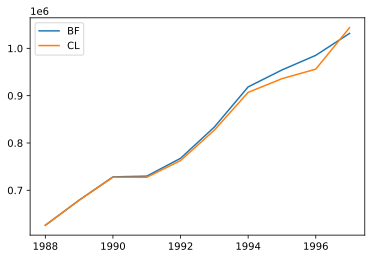

In [19]:
cl_model = cl.Chainladder().fit(comauto["CumPaidLoss"])

plt.plot(
    bf_model.ultimate_.to_frame().index.year, bf_model.ultimate_.to_frame(), label="BF",
)
plt.plot(
    cl_model.ultimate_.to_frame().index.year, cl_model.ultimate_.to_frame(), label="CL",
)
plt.legend(loc="upper left")

### The Benktander Method

The `Benktander` method is similar to the `BornhuetterFerguson` method, but allows for the specification of one additional assumption, `n_iters`, the number of iterations to recalculate the ultimates. The Benktander method generalizes both the `BornhuetterFerguson` and the `Chainladder` estimator through this assumption.

- When `n_iters = 1`, the result is equivalent to the `BornhuetterFerguson` estimator.
- When `n_iters` is sufficiently large, the result converges to the `Chainladder` estimator.

In [20]:
bk_model = cl.Benktander(apriori=0.75, n_iters=2)
bk_model.fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

Benktander(apriori=0.75, n_iters=2)

Fitting the `Benktander` method looks identical to the other methods.

In [21]:
bk_model.fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

Benktander(apriori=0.75, n_iters=2)

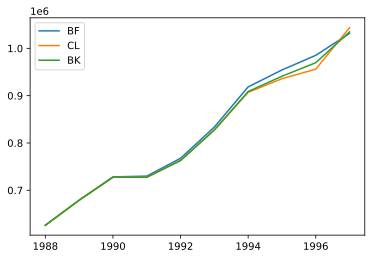

In [22]:
plt.plot(
    bf_model.ultimate_.to_frame().index.year, bf_model.ultimate_.to_frame(), label="BF"
)
plt.plot(
    cl_model.ultimate_.to_frame().index.year, cl_model.ultimate_.to_frame(), label="CL"
)
plt.plot(
    bk_model.ultimate_.to_frame().index.year, bk_model.ultimate_.to_frame(), label="BK"
)
plt.legend(loc="upper left")

### The Cape Cod Method
The `CapeCod` method is similar to the `BornhuetterFerguson` method, except its `apriori` is computed from the `Triangle` itself. Instead of specifying an `apriori`, `decay` and `trend` need to be specified.  

 - `decay` is the rate that gives weights to earlier origin periods, this parameter is required by the Generalized Cape Cod Method, as discussed in [Using Best Practices to Determine a Best Reserve Estimate](https://www.casact.org/sites/default/files/database/forum_98fforum_struhuss.pdf) by Struzzieri and Hussian. As the `decay` factor approaches 1 (the default value), the result approaches the traditional Cape Cod method. As the `decay` factor approaches 0, the result approaches the `Chainladder` method. 
 - `trend` is the trend rate along the origin axis to reflect systematic inflationary impacts on the a priori.

When we `fit` a `CapeCod` method, we can see the `apriori` it computes with the given `decay` and `trend` assumptions. Since it is an array of estimated parameters, this `CapeCod` attribute is called the `apriori_`, with a trailing underscore.

In [23]:
cc_model = cl.CapeCod()
cc_model.fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

CapeCod()

With `decay=1`, each `origin` period gets the same `apriori_` (this is the traditional Cape Cod). The `apriori_` is calculated using the latest diagonal over the used-up exposure, where the used-up exposure is the exposure vector / CDF. Let's validate the calculation of the a priori.

In [24]:
latest_diagonal = comauto["CumPaidLoss"].latest_diagonal

cdf_as_origin_vector = (
    cl.Chainladder().fit(comauto["CumPaidLoss"]).ultimate_
    / comauto["CumPaidLoss"].latest_diagonal
)

latest_diagonal.sum() / (
    comauto["EarnedPremNet"].latest_diagonal / cdf_as_origin_vector
).sum()

0.6856862224535671

With `decay=0`, the `apriori_` for each `origin` period stands on its own.

In [25]:
cc_model = cl.CapeCod(decay=0, trend=0).fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)
cc_model.apriori_

,2261
1988,0.6853
1989,0.7041
1990,0.6903
1991,0.6478
1992,0.6518
1993,0.6815
1994,0.6925
1995,0.7004
1996,0.7039
1997,0.7619


Doing the same on our manually calculated `apriori_` yields the same result.

In [26]:
latest_diagonal / (comauto["EarnedPremNet"].latest_diagonal / cdf_as_origin_vector)

,1997
1988,0.6853
1989,0.7041
1990,0.6903
1991,0.6478
1992,0.6518
1993,0.6815
1994,0.6925
1995,0.7004
1996,0.7039
1997,0.7619


Let's verify the result of this Cape Cod model's result with the Chainladder's.

In [27]:
cc_model.ultimate_ - cl_model.ultimate_

,2261
1988,
1989,
1990,
1991,
1992,0.0000
1993,0.0000
1994,
1995,0.0000
1996,
1997,0.0000


We can examine the `apriori_`s to see whether there exhibit any trends over time.

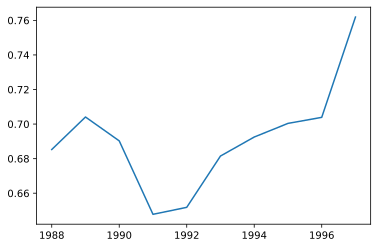

In [28]:
plt.plot(cc_model.apriori_.to_frame().index.year, cc_model.apriori_.to_frame())

Looks like there is a small positive trend, let's judgementally select the `trend` as 1%.

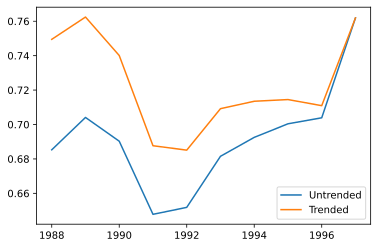

In [29]:
trended_cc_model = cl.CapeCod(decay=0, trend=0.01).fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

plt.plot(
    cc_model.apriori_.to_frame().index.year,
    cc_model.apriori_.to_frame(),
    label="Untrended",
)
plt.plot(
    trended_cc_model.apriori_.to_frame().index.year,
    trended_cc_model.apriori_.to_frame(),
    label="Trended",
)
plt.legend(loc="lower right")

We can of course utilize both the `trend` and the `decay` parameters together. Adding `trend` to the `CapeCod` method is intended to adjust the `apriori_`s to a common level. Once at a common level, the `apriori_` can be estimated from multiple origin periods using the `decay` factor.

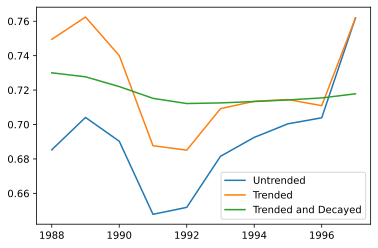

In [30]:
trended_cc_model = cl.CapeCod(decay=0, trend=0.01).fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

trended_decayed_cc_model = cl.CapeCod(decay=0.75, trend=0.01).fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

plt.plot(
    cc_model.apriori_.to_frame().index.year,
    cc_model.apriori_.to_frame(),
    label="Untrended",
)
plt.plot(
    trended_cc_model.apriori_.to_frame().index.year,
    trended_cc_model.apriori_.to_frame(),
    label="Trended",
)
plt.plot(
    trended_decayed_cc_model.apriori_.to_frame().index.year,
    trended_decayed_cc_model.apriori_.to_frame(),
    label="Trended and Decayed",
)
plt.legend(loc="lower right")

Once estimated, it is necessary to detrend our `apriori_`s back to their untrended levels and these are contained in `detrended_apriori_`. It is the `detrended_apriori_` that gets used in the calculation of `ultimate_` losses.

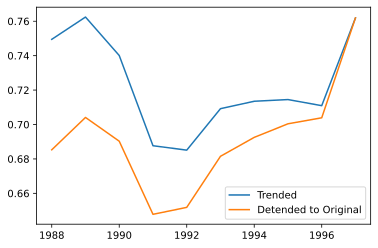

In [31]:
plt.plot(
    trended_cc_model.apriori_.to_frame().index.year,
    trended_cc_model.apriori_.to_frame(),
    label="Trended",
)
plt.plot(
    trended_cc_model.detrended_apriori_.to_frame().index.year,
    trended_cc_model.detrended_apriori_.to_frame(),
    label="Detended to Original",
)
plt.legend(loc="lower right")

The `detrended_apriori_` is a much smoother estimate of the initial expected `ultimate_`.  With the `detrended_apriori_` in hand, the `CapeCod` method estimator behaves exactly like our the `BornhuetterFerguson` model.

In [32]:
bf_model = cl.BornhuetterFerguson().fit(
    X=comauto["CumPaidLoss"],
    sample_weight=trended_cc_model.detrended_apriori_
    * comauto["EarnedPremNet"].latest_diagonal,
)

bf_model.ultimate_.sum() - trended_cc_model.ultimate_.sum()

0.0

### Recap

All the deterministic estimators have `ultimate_`, `ibnr_`, `full_expecation_` and `full_triangle_` attributes that are themselves `Triangle`s.  These can be manipulated in a variety of ways to gain additional insights from our model. The expected loss methods take in an exposure vector, which itself is a `Triangle` through the `sample_weight` argument of the `fit` method. The `CapeCod` method has the additional attributes `apriori_` and `detrended_apriori_` to accommodate the selection of its `trend` and `decay` assumptions.

Finally, these estimators work very well with the transformers discussed in previous tutorials. Let's demonstrate the compositional nature of these estimators.

In [33]:
wkcomp = (
    cl.load_sample("clrd")
    .groupby("LOB")
    .sum()
    .loc["wkcomp"][["CumPaidLoss", "EarnedPremNet"]]
)
wkcomp

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(1, 2, 10, 10)"
Index:,[LOB]
Columns:,"[CumPaidLoss, EarnedPremNet]"


Let's calculate the age-to-age factors:
- Without the the 1995 valuation period
- Using volume weighted for the first 5 factors, and  simple average for the next 4 factors (for a total of 9 age-to-age factors)
- Using no more than 7 periods (with `n_periods`)

In [34]:
patterns = cl.Pipeline(
    [
        (
            "dev",
            cl.Development(
                average=["volume"] * 5 + ["simple"] * 4,
                n_periods=7,
                drop_valuation="1995",
            ),
        ),
        ("tail", cl.TailCurve(curve="inverse_power", extrap_periods=80)),
    ]
)

In [35]:
cc = cl.CapeCod(decay=0.8, trend=0.02).fit(
    X=patterns.fit_transform(wkcomp["CumPaidLoss"]),
    sample_weight=wkcomp["EarnedPremNet"].latest_diagonal,
)
cc.ultimate_

,2261
1988,"1,331,221"
1989,"1,416,505"
1990,"1,523,470"
1991,"1,581,962"
1992,"1,541,458"
1993,"1,484,168"
1994,"1,525,963"
1995,"1,548,534"
1996,"1,541,068"
1997,"1,507,592"


<BarContainer object of 10 artists>

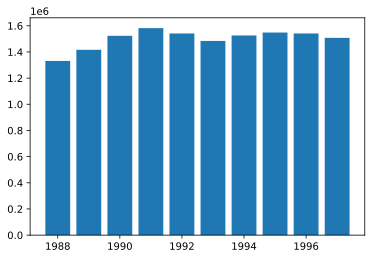

In [36]:
plt.bar(cc.ultimate_.to_frame().index.year, cc.ultimate_.to_frame()["2261"])